# Projet optimisation de la trajectoire d'un robot

# Partie 1

### Question 1

Les inconnues du problème sont les poses $Pi$ de la trajectoire. On pose $P_{i}=(x_{i},y_{i},\theta_{i})$ avec $x_i,y_i,\theta_i$ définis pour $i$ allant de $0$ à $n$ par rapport à un repère fixe ayant pour origine $P_0 = (0,0,0)$.

On cherche à les déterminer grâce aux relations d'odométrie et de fermeture de boucles qui elles sont connues.


### Question 2

Chaque relation d'odométrie est donnée relativement à la pose précédente. 
On a donc les relations suivantes pour l'odométrie : 

$$
\left\{
    \begin{array}{ll}
        x_{i+1} = x_i + dx_i\cos{\theta_i}- dy_i\sin{}\theta_i = f_{x}(x_{i},dx_{i},dy_{i},\theta_{i})\\
        y_{i+1} = y_i + dx_i\sin{\theta_i}+ dy_i\cos{}\theta_i = f_{y}(y_{i},dx_{i},dy_{i},\theta_{i})\\
        \theta_{i+1} = \theta_i + d\theta_i = f_{\theta}(\theta_{i},d\theta_{i})
    \end{array}
\right.
$$

Et on adapte pour les relations de fermetures de boucle en remplaçant $i+1$ par $j$ avec $j$ l'indice de la fermeture de boucle. 

### Question 3

On veut ici déterminer quelle fonction minimiser afin de vérifier au mieux les données d'odométrie et de fermetures de boucles. On va d'abord introduire plusieurs notations.

On va travailler ici avec des fonctions $f_{x}, f_{y} et f_{\theta}$ définies respectivement par les relations données en question 2 s'appliquant sur les variables $x_{i}, y_{i}$ et $\theta_{i}$. De plus, les éléments que nous appelerons $dx_{i},dy_{i}$ et $d\theta_{i}$ ainsi que $dx'_{i},dy'_{i}$ et $d\theta'_{i}$ dans la suite correspondent respectivement aux valeurs d'odométrie et de fermeture de boucles mesurées par le robot lors de son parcours, et sont donc connues et fixées.

Ce faisant, on note $P_{i}=(x_{i},y_{i},\theta_{i})$ un triplet de $R^{3}$ et M le vecteur de dimension 3n définit par $M=(P_{i})_{1 \leqslant i \leqslant n}$. 

Si M est un minimum de notre fonction, on veut que chacun des $p_{i}$ vérifie au mieux les relations d'odométrie et de fermetures de boucles, c'est-à-dire:

1) $\forall i \in {1,...,n}$,
$x_{i+1}\approx f_{x}(x_{i},dx_{i},dy_{i},\theta_{i})$,
$y_{i+1}\approx f_{y}(y_{i},dx_{i},dy_{i},\theta_{i})$,
$\theta_{i+1}\approx f_{\theta}(\theta_{i},d\theta_{i})$.

2) Si l'on note B l'ensemble des couples (j,i) correspondant à des fermetures de boucles détectées par le robot, on veut également vérifier: $x_{j}\approx f_{x}(x_{i},dx'_{i},dy'_{i},\theta_{i})$, 
$y_{j}\approx f_{y}(y_{i},dx'_{i},dy'_{i},\theta_{i})$ et
$\theta_{j}\approx f_{\theta}(\theta_{i},d\theta'_{i})$.

Plus concrètement, ces approximations se traduisent par le fait que les quantités $\left|x_{i+1}- f_{x}(x_{i},dx_{i},dy_{i},\theta_{i}) \right|^{2}$ soient le plus petites possibles, de même en remplaçant les $x$ par les $y$ et les $\theta$, et de même pour les relations de fermeture de boucle.

Comme on veut que cela soit vrai pour toutes ces relations, et que celles-ci sont interdépendantes, cela revient à minimiser la fonction de $R^{3n}$ suivante:

 $M \in R^{3n} \rightarrow \sum_{i=1}^{n} \left\|P_{i+1} - F(P_{i},dx_{i},dy_{i},d\theta_{i}) \right\|^{2} + \sum_{(j,i) \in B} \left\|P_{j} - F(P_{i},dx'_{i},dy'_{i},d\theta'_{i}) \right\|^{2}$ 

où les $P_{i}$ ont été définis ci-dessus comme les triplets composants de M et où $F(P_{i},dx_{i},dy_{i},d\theta_{i})=(f_{x}(x_{i},dx_{i},dy_{i},\theta_{i}),f_{y}(y_{i},dx_{i},dy_{i},\theta_{i}),f_{\theta}(\theta_{i},d\theta_{i}))$. 

# Partie 2

### Question 1

In [116]:
donnees_odo = []
donnees_loop = []

def recup_donnees(fichier):
    with open(fichier, 'r') as intel:
        for ligne in intel:
            l = ligne.split()
            for i in range(1,len(l)):
                l[i]=float(l[i])
            if l[0]=="EDGE_ODO":
                donnees_odo.append(l[1:3]+[l[3:]])
            else:
                donnees_loop.append(l[1:3]+[l[3:]])
                
recup_donnees("INTEL.txt")
donnees_loop


[[19.0, 166.0, [-2.459689, 0.241111, 0.2528]],
 [19.0, 172.0, [1.067903, 0.915786, 0.14947]],
 [25.0, 172.0, [-2.539634, 0.85263, -0.02986]],
 [25.0, 178.0, [1.225223, 0.672079, -0.10248]],
 [32.0, 178.0, [-2.020007, -0.239771, 0.71518]],
 [32.0, 183.0, [-0.092559, 0.424181, 0.0416]],
 [44.0, 189.0, [-2.265706, -0.570857, 0.19772]],
 [44.0, 195.0, [1.302289, -0.133004, -0.00528]],
 [50.0, 195.0, [-2.374379, -0.253682, 0.21612]],
 [50.0, 201.0, [1.291572, 0.086248, -0.0507]],
 [50.0, 203.0, [2.550695, 0.035722, -0.08465]],
 [61.0, 203.0, [-2.852494, 0.122053, 0.07787]],
 [61.0, 209.0, [0.73078, 0.07297, 0.00889]],
 [67.0, 209.0, [-2.822142, 0.138051, -0.00446]],
 [67.0, 220.0, [0.783704, -1.176736, -1.4129]],
 [81.0, 220.0, [-0.868391, -0.009825, -0.04688]],
 [81.0, 226.0, [2.836453, 0.058719, 0.04915]],
 [87.0, 226.0, [-0.45964, 0.184679, 0.34383]],
 [87.0, 231.0, [1.060624, 0.863823, 0.29401]],
 [94.0, 231.0, [-2.231597, 0.316386, 0.18025]],
 [94.0, 241.0, [2.816677, 0.483252, 0.0414]

### Question 2

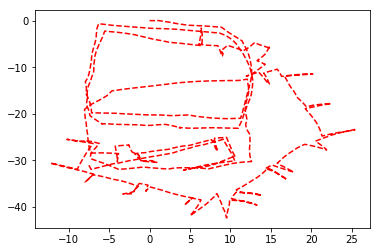

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

def estim_trajectoire(odometrie):
    liste_x = [0]
    liste_y = [0]
    liste_theta = [0]
    for i in range(len(odometrie)):
        p_i = np.array([liste_x[-1], liste_y[-1], liste_theta[-1]])
        di = np.array(odometrie[i][2])
        rot = np.array([[cos(p_i[2]), -sin(p_i[2]), 0], [sin(p_i[2]),cos(p_i[2]), 0], [0, 0, 1]])
        p_i = p_i + np.dot(rot, di)
        liste_x.append(p_i[0])
        liste_y.append(p_i[1])
        liste_theta.append(p_i[2]%(2*pi))
    return liste_x, liste_y, liste_theta

x, y, t = estim_trajectoire(donnees_odo)
plt.figure()
plt.plot(x, y, 'r--')
plt.show()
        


### Question 3

La fonction n'est pas convexe à cause des termes en cos$\theta_{i}$ et sin$\theta_{i}$. Par exemple, en reprenant l'estimation précédente et en faisant varier theta pour une pose, on observe un comportement de la fonction oscillatoire selon cette variable, donc non convexe:

[ 2.91429729 -0.49425272  5.96360961]


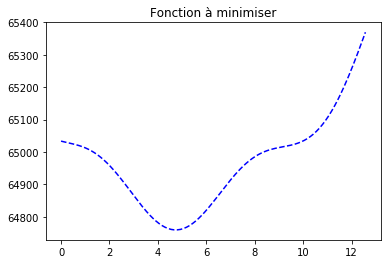

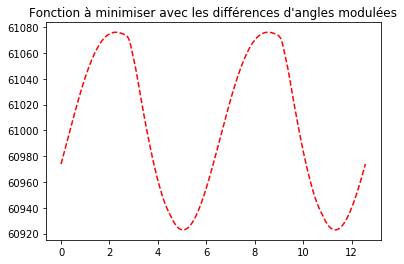

In [140]:
def F(p_i,di):
    rot = np.array([[cos(p_i[2]), -sin(p_i[2]), 0], [sin(p_i[2]),cos(p_i[2]), 0], [0, 0, 1]])
    p_i = p_i + np.dot(rot, di)
    return p_i
    
def f_minim_pose(P,i):
    #Partie odométrie
    p_i=np.array(P[i])
    pi_1=np.array(P[i+1])
    relations_odo=[]
    if i<len(donnees_odo):
        relations_odo = donnees_odo[i]
    diff_o=pi_1-F(p_i,np.array(relations_odo[2]))
    a=(np.linalg.norm(diff_o))**2

    #Partie loop
    relations_loop = [item for item in donnees_loop if item[0]==i] #Pas les relations où i est le deuxième indice pour ne pas compter les relations 2 fois
    indexes_loop = [int(item[1]) for item in relations_loop]
    Pj=[np.array(P[j]) for j in indexes_loop]
    for k in range(len(relations_loop)):
        diff=Pj[k]-F(p_i,np.array(relations_loop[k][2]))
        a+=(np.linalg.norm(diff))**2
    return a

def mod_diff(diff):
    if diff<=0:
        diff=-(-diff)%(2*pi)
    return diff

def f_minim_pose_v2(P,i): 
    """Cette version de la fonction prend en compte uniquement la différence modulo 2pi entre les angles au lieu d'une différence 
    absolue comme c'est le cas dans la fonction que nous avons définie en partie 1. Elle met simplement mieux en évidence le 
    comportement oscillatoire de la fonction et traduit la periodicité physique de la solution au problème (une pose dont le theta 
    vaut 0 ou 2pi rend compte de la même réalité physique, mais dans la fonction à minimiser, seul l'un des deux angles minimise la
    différence entre thetai et f(theta(i-1))"""
    #Partie odométrie
    p_i=np.array(P[i])
    pi_1=np.array(P[i+1])
    relations_odo=[]
    if i<len(donnees_odo):
        relations_odo = donnees_odo[i]
    diff_o=pi_1-F(p_i,np.array(relations_odo[2]))
    diff_o[2]=mod_diff(diff_o[2])
    diff_o[2]= min(diff_o[2],2*pi-diff_o[2])
    a=(np.linalg.norm(diff_o))**2

    #Partie loop
    relations_loop = [item for item in donnees_loop if item[0]==i] #Pas les relations où i est le deuxième indice pour ne pas compter les relations 2 fois
    indexes_loop = [int(item[1]) for item in relations_loop]
    Pj=[np.array(P[j]) for j in indexes_loop]
    for k in range(len(relations_loop)):
        diff=Pj[k]-F(p_i,np.array(relations_loop[k][2]))
        diff[2]=mod_diff(diff[2])
        diff[2]= min(diff[2],2*pi-diff[2])
        a+=(np.linalg.norm(diff))**2
    return a

def f_minim(P):
    return sum([f_minim_pose(P,i) for i in range(len(donnees_odo))])

def f_minim_v2(P):
    return sum([f_minim_pose_v2(P,i) for i in range(len(donnees_odo))])

P=np.array([[x[i],y[i],t[i]] for i in range(len(x))])

k=19

print(P[k])

liste_theta=np.linspace(0,4*pi,200)
liste_f=[]
liste_f2=[]
for i in range(200):
    P[k][2]=liste_theta[i]
    liste_f.append(f_minim(P))
    liste_f2.append(f_minim_v2(P))
    
plt.figure()
plt.plot(liste_theta, liste_f, 'b--')
plt.title("Fonction à minimiser")

plt.figure(2)
plt.plot(liste_theta, liste_f2, 'r--')
plt.title("Fonction à minimiser avec les différences d'angles modulées")

plt.show()

### Question 4

Même si la fonction n'est pas convexe, les oscillations très légères comparées au caractère quadratique de la fonction nous permettent de penser qu'une méthode de descente de gradient à pas variable avec conditions de Wolfe ne nous mènera pas à un minimum local. On part de l'estimation avec les relations d'odométrie seulement.

In [ ]:
def grad_f_minim(P):
    return P

# Conditions de Wolfe
def wolfe_step(fun, grad_fun, xk, pk, c1 = 0.25, c2 = 0.75, M = 1000):
    l_moins = 0
    l_plus = 0
    f_xk = fun(xk)
    grad_f_xk = grad_fun(xk)
    li = 1 #- 2*0.1*abs(f_x) / np.dot(grad_f_x,d)
    i = 0
    while(i < M):
        if (fun(xk+li*pk)>(f_xk+c1*li*np.dot(grad_f_xk,pk))):
            l_plus = li
            li = (l_moins+l_plus)/2.0
        else:
            if (np.dot(grad_fun(xk+li*pk),pk) < c2*np.dot(grad_f_xk,pk)):
                l_moins = li
                if (l_plus == 0):
                    li = 2*li
                else:
                    li = (l_moins+l_plus)/2.0
            else:
                return li
        i = i + 1
    return li

def optim_gradient_wolfe_step(fun, grad_fun, x0, max_iter = 100000, epsilon_grad_fun = 1e-8):
    k = 0
    xk = x0
    grad_f_xk = grad_fun(xk)
    while ((k<max_iter) and (np.linalg.norm(grad_f_xk)>epsilon_grad_fun)):
        pk = -grad_f_xk
        lk = wolfe_step(fun, grad_fun, xk, pk)
        xk = xk + lk*pk
        grad_f_xk = grad_fun(xk)
        k = k + 1
    print("Nombre d'iterations : ", k)
    return xk
